In [46]:
## Importing important stuff
import random
import numpy as np
import pandas as pd
from PIL import Image 
import tifffile as tiff
from tifffile import imsave
             ###############
#plotting
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go

# Run this code to make plots display properly in notebooks
%matplotlib inline
            ####################

import pickle as pkl
import time

In [2]:
#machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical   
###
from keras import models
from keras import layers
###
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
####
import os

Using TensorFlow backend.


#### Functions for analysis

In [ ]:
# do not run this 
import scipy.misc
scipy.misc.imsave('path', img)

In [3]:
#Takes an index of the image you want to save ---> Creates a tiff file with 3 frames,
## - first one is input (Low Signal to Noise Ratio)
## - second is is Ground Truth (High SNR)
## - Third one is predicted 
## Exports that to local folder called 'analysis_files'
def save_multi_tif(i):
    #creating the list 
    init_list=[0,0,0]
    init_list[0] = x_TT_orig[i]
    init_list[1] = y_TT_orig[i]
    init_list[2] = new_pre_sc[i].reshape(128,128)*3020.0
    #changing the list a numpy array and reshaping
    nparr= np.asarray(init_list).reshape(3,128,128,1)
    #changing to 16 bit
    corr_array = np.uint16(nparr)
    ## saving it
    imsave('/users/PAS1495/akl2/work/increase_SNR/analysis_files/multi_'+str(i)+'.tif', corr_array)


In [33]:
### Creating a function to load up measurements for a cell 
## Takes a csv file path that is created by imageJ measurement 
## Outputs lists that has maximum value of each spot, minimum value, mean value, and total intesity. 
## The area of a specific spot is kept constant over all the frames 
## Output is a dictionary and you access the disired list by two keys, x/y/pred and max/min/mean/tot and norm/notnorm
## Measurement made by analyzing the 3 frame tiff file that was the output of the previous image 
# gives back both normalized and non normalized lists of 
# max, min, mean, total intensity
def read_lists_imgJ(path):
    data = pd.read_csv(str(path)) 
    y_index = list(range(0,len(data),3))
    pred_index = list(range(1,len(data),3))
    x_index = list(range(2,len(data),3))
    #Max, min and mean lists
    max_y_list = data.iloc[y_index, 4].values
    max_x_list = data.iloc[x_index, 4].values
    max_pred_list = data.iloc[pred_index, 4].values
    min_y_list = data.iloc[y_index, 3].values
    min_x_list = data.iloc[x_index, 3].values
    min_pred_list = data.iloc[pred_index, 3].values
    mean_y_list = data.iloc[y_index, 2].values
    mean_x_list = data.iloc[x_index, 2].values
    mean_pred_list = data.iloc[pred_index, 2].values
    ######## Normalization 
    norm_max_y_list = max_y_list/max_y_list[0]
    norm_max_x_list = max_x_list/max_x_list[0]
    norm_max_pred_list = max_pred_list/max_pred_list[0]
    norm_min_y_list = min_y_list/min_y_list[0]
    norm_min_x_list = min_x_list/min_x_list[0]
    norm_min_pred_list = min_pred_list/min_pred_list[0]
    norm_mean_y_list = mean_y_list/mean_y_list[0]
    norm_mean_x_list = mean_x_list/mean_x_list[0]
    norm_mean_pred_list = mean_pred_list/mean_pred_list[0]
    ## How does total intensity compare??
    area_list = data.iloc[y_index, 1].values
    tot_int_x = mean_x_list*area_list
    tot_int_y = mean_y_list*area_list
    tot_int_pred = mean_pred_list*area_list
    norm_tot_int_x = tot_int_x/tot_int_x[0]
    norm_tot_int_y = tot_int_y/tot_int_y[0]
    norm_tot_int_pred =tot_int_pred/tot_int_pred[0]
    list_dic={'x':{'mean':{'norm':norm_mean_x_list, 'notnorm': mean_x_list},
                   'max':{'norm':norm_max_x_list, 'notnorm': max_x_list},
                   'min':{'norm':norm_min_x_list, 'notnorm': min_x_list},
                   'tot':{'norm':norm_tot_int_x, 'notnorm': tot_int_x}},
         'y':{'mean':{'norm':norm_mean_y_list, 'notnorm': mean_y_list},
                   'max':{'norm':norm_max_y_list, 'notnorm': max_y_list},
                   'min':{'norm':norm_min_y_list, 'notnorm': min_y_list},
                   'tot':{'norm':norm_tot_int_y, 'notnorm': tot_int_y}},
         'pred':{'mean':{'norm':norm_mean_pred_list, 'notnorm': mean_pred_list},
                   'max':{'norm':norm_max_pred_list, 'notnorm': max_pred_list},
                   'min':{'norm':norm_min_pred_list, 'notnorm': min_pred_list},
                   'tot':{'norm':norm_tot_int_pred, 'notnorm': tot_int_pred}},
             'area':area_list}
    return list_dic

    

In [42]:
#need to define path before running this
def extract_noise_lists(path):
    the_dictionary= read_lists_imgJ(path)
    cell_num= len(the_dictionary['x']['mean']['norm'])
    small_area_index = list(range(0,cell_num,2))
    big_area_index = list(range(1,cell_num,2))
    ## Create the seperate lists 
    ##
    #total intensity 
    tot_int_small_y = the_dictionary['y']['tot']['notnorm'][small_area_index]
    tot_int_big_y = the_dictionary['y']['tot']['notnorm'][big_area_index]
    tot_int_small_pred = the_dictionary['pred']['tot']['notnorm'][small_area_index]
    tot_int_big_pred = the_dictionary['pred']['tot']['notnorm'][big_area_index]
    #area
    area_small = the_dictionary['area'][small_area_index]
    area_big = the_dictionary['area'][big_area_index]
    ## diff in area
    diff_area = area_big - area_small
    #diff in intensity
    diff_int_y = tot_int_big_y - tot_int_small_y
    diff_int_pred = tot_int_big_pred - tot_int_small_pred
    
    ### mean
    mean_noisy_y= diff_int_y/diff_area
    mean_noisy_pred = diff_int_pred/diff_area
    ### 
    new_mean_y = the_dictionary['y']['mean']['notnorm'][small_area_index] - mean_noisy_y
    new_mean_pred = the_dictionary['pred']['mean']['notnorm'][small_area_index] - mean_noisy_pred
    ### removing total noise 
    tot_noise_y = mean_noisy_y* area_small
    tot_noise_pred = mean_noisy_pred*area_small
    #######     new_tot_y = 
    new_tot_y = tot_int_small_y - tot_noise_y
    new_tot_pred = tot_int_small_pred - tot_noise_pred
    #nw and imporoved max and min
    new_max_y = the_dictionary['y']['max']['notnorm'][small_area_index] - mean_noisy_y
    new_min_y = the_dictionary['y']['min']['notnorm'][small_area_index] - mean_noisy_y
    new_max_pred = the_dictionary['pred']['max']['notnorm'][small_area_index] - mean_noisy_pred
    new_min_pred = the_dictionary['pred']['max']['notnorm'][small_area_index] - mean_noisy_pred
    #
    list_dict ={'y':{'mean':new_mean_y,'max':new_max_y,'tot':new_tot_y,'min':new_min_y},
                'pred':{'mean':new_mean_pred,'max':new_max_pred,'tot':new_tot_pred,'min':new_min_pred}} 
    return list_dict
    #
    #
    #
    #
    #

#### Loading and predicting data to be analyzed 

In [6]:
#load testing data
x_TT_orig = np.load('x_true_test_128.npy')
y_TT_orig = np.load('y_true_test_128.npy')

# reshape them 
x_TT = x_TT_orig.reshape(x_TT_orig.shape[0],128,128,1)
y_TT = y_TT_orig.reshape(y_TT_orig.shape[0],128,128,1)
# normalize 
x_TT_sc = x_TT/3020.0
y_TT_sc = y_TT/3020.0


In [7]:
#predict the testing data. 
model = load_model('UNET_128_short.h5')
new_pre_sc= model.predict(x_TT_sc[:1000])

In [11]:
path= '/users/PAS1495/akl2/work/increase_SNR/analysis_files/sample[0] total square intensities.csv'
sam_0_dic= lists_for_plot(path)

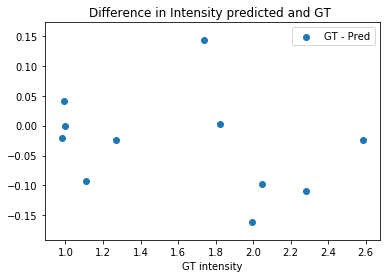

In [146]:
y_0_tot = sam_0_dic['y']['tot']
pred_0_tot= sam_0_dic['pred']['tot']
diff_list= pred_0_tot - y_0_tot
## plotting
#plt.scatter(range(len(y_0_tot)),y_0_tot, label = 'GT')
#plt.scatter(range(len(y_0_tot)),pred_0_tot, label = 'Predicted')
plt.scatter(y_0_tot,diff_list, label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('GT intensity')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('Difference in Intensity predicted and GT ')
plt.legend()
plt.show()

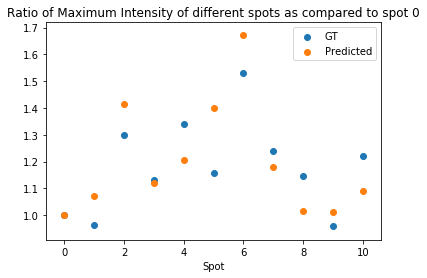

In [142]:
y_0_tot = sam_0_dic['y']['max']
pred_0_tot= sam_0_dic['pred']['max']
#diff_list= pred_0_tot - y_0_tot
## plotting
#plt.scatter(range(len(y_0_tot)),y_0_tot, label = 'GT')
#plt.scatter(range(len(y_0_tot)),pred_0_tot, label = 'Predicted')
#lt.scatter(range(len(y_0_tot)),diff_list, label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Spot')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('Ratio of Maximum Intensity of different spots as compared to spot 0')
plt.legend()
plt.show()

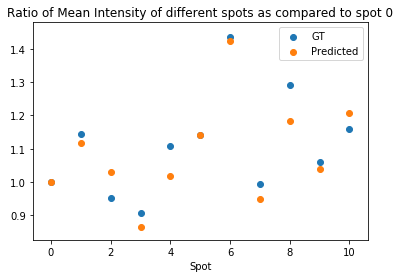

In [147]:
y_0_tot = sam_0_dic['y']['mean']
pred_0_tot= sam_0_dic['pred']['mean']
#diff_list= pred_0_tot - y_0_tot
## plotting
plt.scatter(range(len(y_0_tot)),y_0_tot, label = 'GT')
plt.scatter(range(len(y_0_tot)),pred_0_tot, label = 'Predicted')
#plt.scatter(range(len(y_0_tot)),diff_list, label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Spot')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('Ratio of Mean Intensity of different spots as compared to spot 0')
plt.legend()
plt.show()

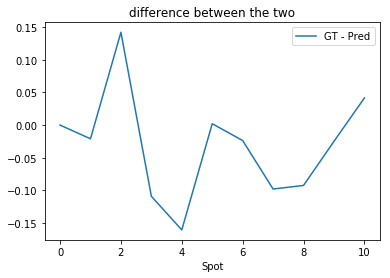

In [17]:
## plotting
#plt.plot(y_0_tot, label = 'GT')
#plt.plot(pred_0_tot, label = 'Predicted')
plt.plot(diff_list, label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Spot')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('difference between the two')
plt.legend()
plt.show()

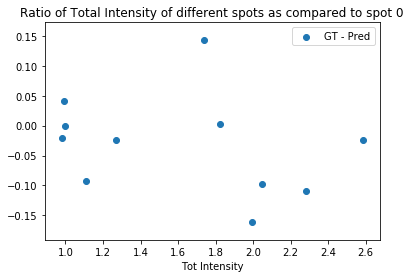

In [20]:
#y_0_tot = sam_0_dic['y']['tot']
#pred_0_tot= sam_0_dic['pred']['tot']
#diff_list= pred_0_tot - y_0_tot
## plotting
#plt.plot(y_0_tot, label = 'GT')
#plt.plot(y_0_totpred_0_tot, label = 'Predicted')
plt.scatter(y_0_tot,diff_list, label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Tot Intensity')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('Ratio of Total Intensity of different spots as compared to spot 0')
plt.legend()
plt.show()

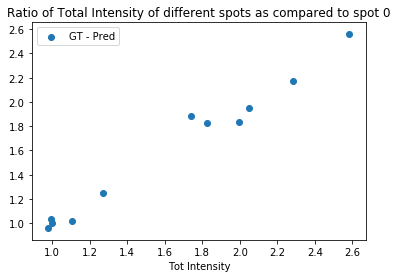

In [22]:
plt.scatter(y_0_tot,pred_0_tot)
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Tot Intensity')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('Ratio of Total Intensity of different spots as compared to spot 0')
plt.legend()
plt.show()

In [21]:
### pretty random, there is no pattern to what the network ends up predicting

y_0_tot_sc = y_0_tot*y_0_tot[0]
print(y_0_tot_sc)

[1.         0.97992341 1.73930745 2.28381852 1.99473047 1.8251928
 2.58487566 2.04827243 1.10779017 1.27114288 0.99422074]


In [25]:
#### creating multi-frame tiff files to be able to analyze them on imageJ
for i in range(1,20):
    save_multi_tif(i)

In [137]:
num = 7

In [162]:
import numpy as np

In [7]:
acc_tot_x = []
acc_tot_y=[]
acc_tot_pred=[]
for i in range(4):
    path ='/users/PAS1495/akl2/work/increase_SNR/analysis_files/sam_'+str(i)+'.csv'
    dic_lists = lists_for_plot(path)
    acc_tot_x.append(dic_lists['x']['tot'])
    acc_tot_y.append(dic_lists['y']['tot'])
    acc_tot_pred.append(dic_lists['pred']['tot'])

In [8]:
# flattenning and prepping the things for plotting 
tot_x = np.concatenate(np.asarray(acc_tot_x)).ravel()
tot_x = tot_x.reshape(1, len(tot_x))
tot_y = np.concatenate(np.asarray(acc_tot_y)).ravel()
tot_y = tot_x.reshape(1, len(tot_y))
tot_pred = np.concatenate(np.asarray(acc_tot_pred)).ravel()
tot_x = tot_pred.reshape(1, len(tot_pred))
##### normalization
tot_x_norm = tot_x / tot_x[0][0]
tot_y_norm = tot_y / tot_y[0][0]
tot_pred_norm = tot_pred/ tot_pred[0]
#### 
tot_x_norm = tot_x_norm.ravel()
tot_y_norm = tot_y_norm.ravel()
tot_pred_norm = tot_pred_norm.ravel()

diff = tot_pred_norm - tot_y_norm

In [14]:
print(len(diff))

59


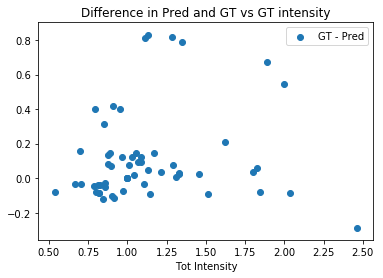

In [15]:
plt.scatter(tot_y_norm , diff, label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Tot Intensity')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('Difference in Pred and GT vs GT intensity')
plt.legend()
plt.show()

In [158]:
len(tot_y_norm)

TypeError: 'numpy.ndarray' object is not callable

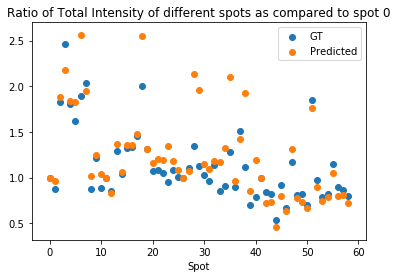

In [155]:
#y_0_tot = sam_0_dic['y']['tot']
#pred_0_tot= sam_0_dic['pred']['tot']
#diff_list= pred_0_tot - y_0_tot
## plotting
plt.scatter(range(len(tot_y_norm)),tot_y_norm, label = 'GT')
plt.scatter(range(len(tot_y_norm)),tot_pred_norm, label = 'Predicted')
#plt.scatter(range(len(y_0_tot)),diff_list, label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Spot')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('Ratio of Total Intensity of different spots as compared to spot 0')
plt.legend()
plt.show()

In [106]:
tot_pred_norm==1

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [94]:
path_0 ='/users/PAS1495/akl2/work/increase_SNR/analysis_files/sam_'+str(0)+'.csv'
sam_0_dic = lists_for_plot(path_0)
path_1 ='/users/PAS1495/akl2/work/increase_SNR/analysis_files/sam_'+str(1)+'.csv'
sam_1_dic = lists_for_plot(path)
path_2 ='/users/PAS1495/akl2/work/increase_SNR/analysis_files/sam_'+str(2)+'.csv'
sam_2_dic = lists_for_plot(path_2)
path_3 ='/users/PAS1495/akl2/work/increase_SNR/analysis_files/sam_'+str(3)+'.csv'
sam_3_dic = lists_for_plot(path_3)
path_4 ='/users/PAS1495/akl2/work/increase_SNR/analysis_files/sam_'+str(4)+'.csv'
sam_4_dic = lists_for_plot(path_4)



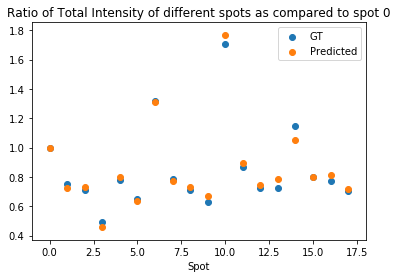

In [118]:
plt.scatter(range(len(sam_2_dic['y']['tot'])),sam_2_dic['y']['tot'], label = 'GT')
plt.scatter(range(len(sam_2_dic['y']['tot'])),sam_2_dic['pred']['tot'], label = 'Predicted')
#plt.scatter(range(len(y_0_tot)),sam_2_dic['pred']['tot']-sam_2_dic['y']['tot'], label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Spot')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('Ratio of Total Intensity of different spots as compared to spot 0')
plt.legend()
plt.show()

In [121]:
one = sam_2_dic['pred']['tot'].shape
two = sam_2_dic['y']['tot']
one-two

array([17.        , 17.24514061, 17.28653335, 17.50465587, 17.21995717,
       17.3492006 , 16.68379464, 17.21122322, 17.28641745, 17.37070046,
       16.29664675, 17.13533128, 17.27526462, 17.27273547, 16.85362535,
       17.19776488, 17.22708838, 17.29355038])

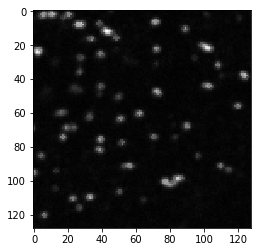

In [124]:
plt.imshow(y_TT_orig[0])

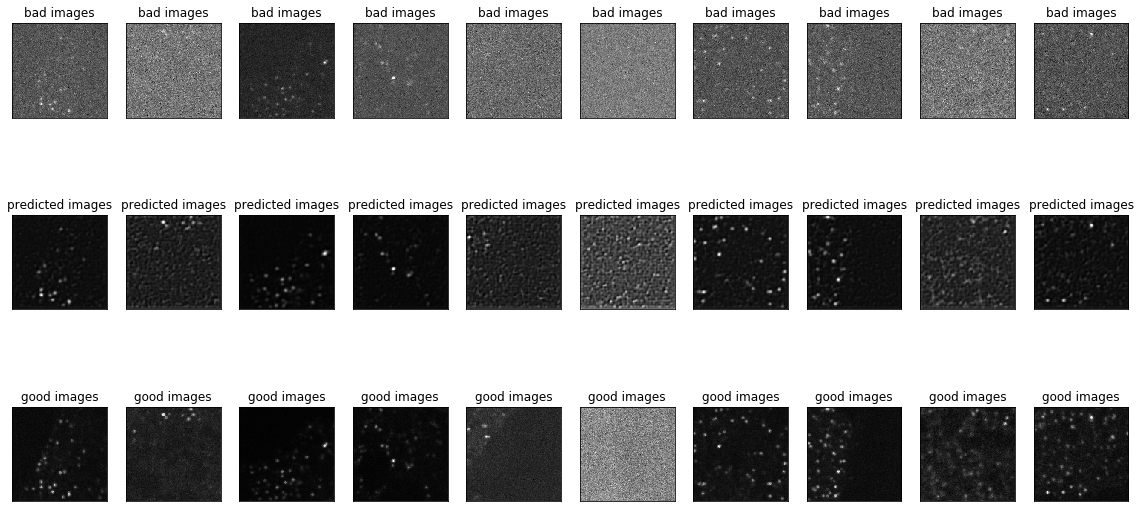

In [5]:
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    
    ax1 = plt.subplot(3, n, i + 1)
    ax1.title.set_text('bad images')
    plt.imshow(x_TT_sc[i+20].reshape(128, 128))
    plt.gray()
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
        # display reconstruction
    
    ax2 = plt.subplot(3, n, i + 1 + n)
    ax2.title.set_text('predicted images')
    plt.imshow(new_pre_sc[i+20].reshape(128, 128))
    plt.gray()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
            # display reconstruction
    
    ax3 = plt.subplot(3, n, i + 1 + n+n)
    ax3.title.set_text('good images')
    plt.imshow(y_TT_sc[i+20].reshape(128, 128))
    plt.gray()
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)

plt.show()

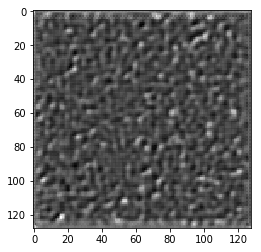

In [14]:
plt.imshow(new_pre_sc[17].reshape(128, 128)*3020.0)

In [11]:
path= '/users/PAS1495/akl2/work/increase_SNR/analysis_files/csv_sam0_big_small_area.csv'
listdic_0= read_lists_imgJ(path)

In [20]:
print(len(lb
          istdic_0['x']['mean']['notnorm']))

22


In [21]:
## extracting the big from the small. 
thelist = listdic_0['x']['mean']['notnorm']

In [43]:
dic=extract_noise_lists(path)

In [55]:
## normalize the lists 
y_tot_norm = dic['y']['tot']/dic['y']['tot'][0]
pred_tot_norm = dic['pred']['tot']/dic['pred']['tot'][0]
y_mean_norm = dic['y']['mean']/dic['y']['mean'][0]
pred_mean_norm = dic['pred']['mean']/dic['pred']['mean'][0]

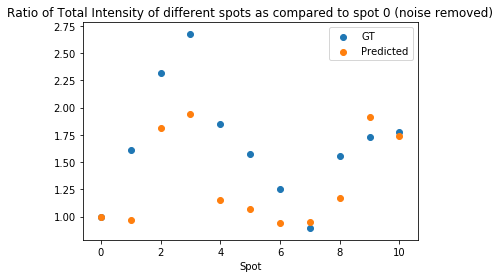

In [61]:
plt.scatter(range(len(y_tot_norm)),y_tot_norm, label = 'GT')
plt.scatter(range(len(y_tot_norm)),pred_tot_norm, label = 'Predicted')
#plt.scatter(range(len(y_0_tot)),sam_2_dic['pred']['tot']-sam_2_dic['y']['tot'], label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Spot')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('Ratio of Total Intensity of different spots as compared to spot 0 (noise removed)')
plt.legend()
plt.show()

In [53]:
diff = y_tot_norm - pred_tot_norm

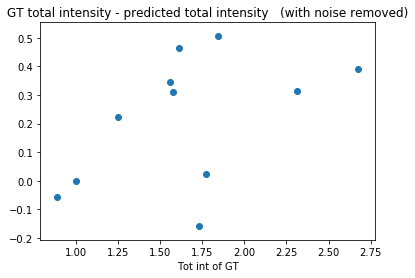

In [60]:
plt.scatter(y_tot_norm,diff)
#plt.scatter(range(len(y_tot_norm)),pred_tot_norm, label = 'Predicted')
#plt.scatter(range(len(y_0_tot)),sam_2_dic['pred']['tot']-sam_2_dic['y']['tot'], label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Tot int of GT')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('GT total intensity - predicted total intensity   (with noise removed)')
#plt.legend()
plt.show()

In [49]:
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go

# Run this code to make plots display properly in notebooks
%matplotlib inline

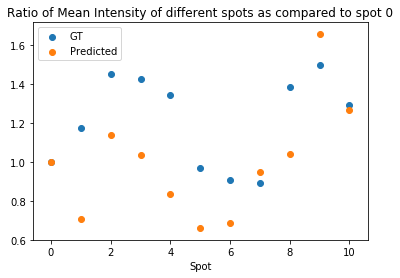

In [56]:
plt.scatter(range(len(y_tot_norm)),y_mean_norm, label = 'GT')
plt.scatter(range(len(y_tot_norm)),pred_mean_norm, label = 'Predicted')
#plt.scatter(range(len(y_0_tot)),sam_2_dic['pred']['tot']-sam_2_dic['y']['tot'], label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Spot')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('Ratio of Mean Intensity of different spots as compared to spot 0')
plt.legend()
plt.show()

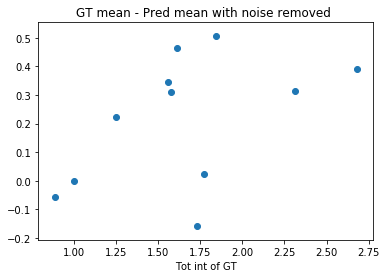

In [59]:
diff = y_mean_norm - pred_mean_norm
plt.scatter(y_tot_norm,diff)
#plt.scatter(range(len(y_tot_norm)),pred_tot_norm, label = 'Predicted')
#plt.scatter(range(len(y_0_tot)),sam_2_dic['pred']['tot']-sam_2_dic['y']['tot'], label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Tot int of GT')
#plt.ylabel('Max intensity/Max intensity of spot 0')
plt.title('GT mean - Pred mean with noise removed ')
#plt.legend()
plt.show()

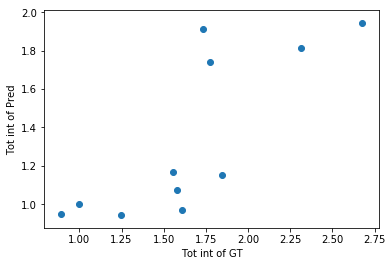

In [62]:
diff = y_mean_norm - pred_mean_norm
plt.scatter(y_tot_norm,pred_tot_norm)
#plt.scatter(range(len(y_tot_norm)),pred_tot_norm, label = 'Predicted')
#plt.scatter(range(len(y_0_tot)),sam_2_dic['pred']['tot']-sam_2_dic['y']['tot'], label = 'GT - Pred')
#plt.plot(norm_tot_int_x, label = 'Low SNR')
plt.xlabel('Tot int of GT')
plt.ylabel('Tot int of Pred')
#plt.legend()
plt.show()